Window function: hamming
Amplitude Correction Factor (ACF): 1.8522 (5.35 dB)
Energy Correction Factor (ECF): 1.5865 (4.01 dB)
f_target: 1000 Hz
f (adjusted): 996.09375 Hz
Bin size: 11.72 Hz
Frequency adjustment strategy: snap
Plot Peak Frequency: 996.09 Hz
Plot Peak Amplitude: 0.9970 (-0.03 dBV)
RMS Energy of the Entire Spectrum (excluding DC and Nyquist): 0.9970 (-0.03 dBV)
RMS Energy from 900 Hz to 1100 Hz: 0.9970 (-0.03 dBV)


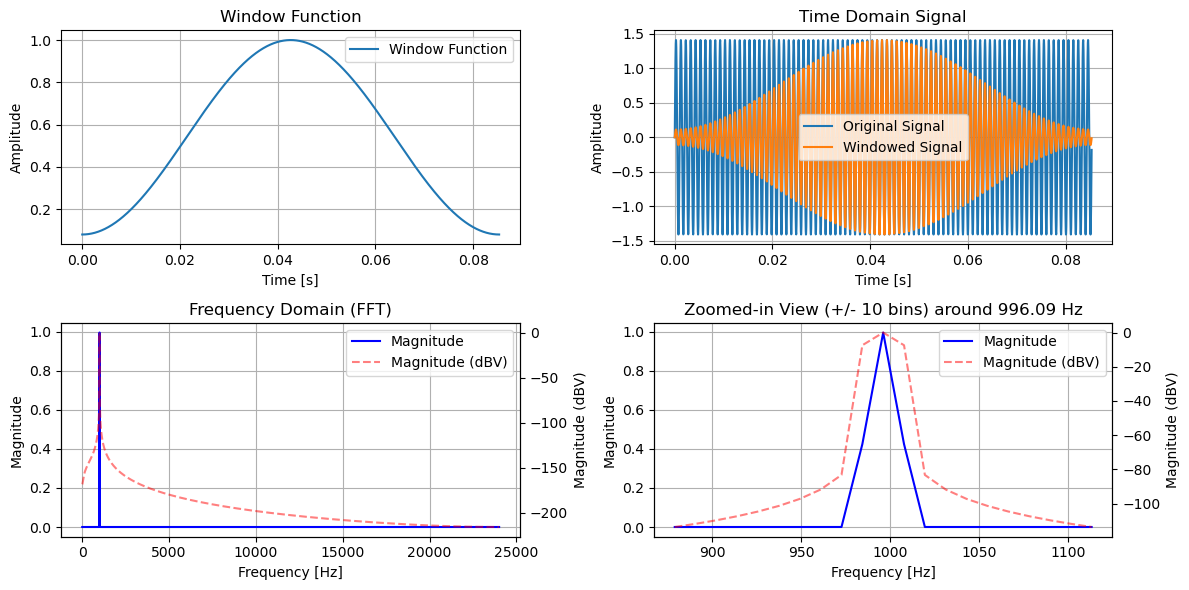

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import flattop, boxcar, hamming
from scipy.fft import rfft, rfftfreq

#
# A standalone file that demonstrates how to preserve amplitudes
# and energy measurements across changes in FFT size, windows, etc

# Define the parameters

# FFT Size. Use power of two
N = 4096

# Sampel rate
fs = 48000  

# Target frequency in Hz. 
f_target = 1000

# Choose the window function
window_function = 'hamming'  # Change to 'flattop', 'boxcar', or 'hamming'

# This sets the target frequency adjustment strategy.
# none will not make a change to the target frequency
# snap will nudge the frequency to the center of the nearest bin
# straddle will nudge the frequency such that it straddles two bins
f_adjust_strategy = 'snap'  # Set to 'none', 'snap', or 'straddle'

##################################
##################################
##################################

bin_resolution = fs / N

# Adjust f_target based on the provided strategy
if f_adjust_strategy == 'snap':
    f = round(f_target / bin_resolution) * bin_resolution
elif f_adjust_strategy == 'straddle':
    bin_index = round(f_target / bin_resolution)
    f = (bin_index + 0.5) * bin_resolution
else:
    f = f_target

t = np.arange(N) / fs  # Time vector

# Create a sinusoidal signal with a peak amplitude of 1.41 = 0 dBV
amplitude = 1.41
signal = amplitude * np.sin(2 * np.pi * f * t)

if window_function == 'flattop':
    window = flattop(N)
elif window_function == 'boxcar':
    window = boxcar(N)
elif window_function == 'hamming':
    window = hamming(N)
else:
    raise ValueError("Unknown window function")

# Compute the Amplitude Correction Factor (ACF). This factor is used to correct the
# FFT results so that the amplitudes are correctly plotted. The ACF for a boxcar is 1.0
mean_w = np.mean(window)
ACF = 1 / mean_w

# Compute the Energy Correction Factor (ECF). This factor is used to ensure accurate
# energy calculations when integrating across the frequency domain. In the time domain,
# the RMS (Root Mean Square) value of a signal can be calculated directly using the formula:
# RMS = sqrt(mean(signal**2)). However, in the frequency domain, to accurately calculate
# the RMS energy over a range of frequencies, RMS = sqrt(sum(signal**2))*ECF
rms_w = np.sqrt(np.mean(window**2))
ECF = 1 / rms_w

# Print the window function, correction factors, frequencies, and bin size
print(f"Window function: {window_function}")
print(f"Amplitude Correction Factor (ACF): {ACF:.4f} ({20 * np.log10(ACF):.2f} dB)")
print(f"Energy Correction Factor (ECF): {ECF:.4f} ({20 * np.log10(ECF):.2f} dB)")
print(f"f_target: {f_target} Hz")
print(f"f (adjusted): {f} Hz")
print(f"Bin size: {bin_resolution:.2f} Hz")
print(f"Frequency adjustment strategy: {f_adjust_strategy}")

# Apply the selected window
windowed_signal = signal * window

# Perform the FFT and normalize. Normalizing means that, regardless of the FFT size, 
# we'll still arrive at the same amplitude for a given time-domain signal Note the rfft
# assumes real input data, and computes only the positive freq components
fft_result = rfft(windowed_signal)
fft_normalized = (np.abs(fft_result) / (N / 2)) / np.sqrt(2)

# Apply the ACF to the entire FFT magnitude. With this step, a 0 dBV sine will have
# a peak of 0 dBV
fft_magnitude_acf = fft_normalized * ACF
fft_magnitude_acf_dBV = 20 * np.log10(fft_magnitude_acf)  # Convert to dBV

# Compute the frequencies corresponding to the positive half of the FFT
frequencies = rfftfreq(N, d=1/fs)

# Find the peak in the corrected FFT magnitude
peak_index = np.argmax(fft_magnitude_acf)  # Consider only the positive frequencies
plot_peak_frequency = peak_index * bin_resolution
peak_amplitude = fft_magnitude_acf[peak_index]
peak_amplitude_dBV = 20 * np.log10(peak_amplitude)

# Compute the RMS energy of the entire spectrum (excluding DC and Nyquist bins)
rms_energy_entire_spectrum = np.sqrt(np.sum(fft_normalized[1:]**2)) * ECF
rms_energy_entire_spectrum_dBV = 20 * np.log10(rms_energy_entire_spectrum)

# Compute the RMS energy from start frequency to stop frequency
start_freq = 900
stop_freq = 1100

# Find the indices corresponding to start and stop frequencies
start_index = np.searchsorted(frequencies, start_freq, side='left')
stop_index = np.searchsorted(frequencies, stop_freq, side='right')

# Compute the RMS energy within the specified frequency range
rms_energy_range = np.sqrt(np.sum(fft_normalized[start_index:stop_index]**2)) * ECF
rms_energy_range_dBV = 20 * np.log10(rms_energy_range)

# Print frequency domain peak values
print(f"Plot Peak Frequency: {plot_peak_frequency:.2f} Hz")
print(f"Plot Peak Amplitude: {peak_amplitude:.4f} ({peak_amplitude_dBV:.2f} dBV)")
print(f"RMS Energy of the Entire Spectrum (excluding DC and Nyquist): {rms_energy_entire_spectrum:.4f} ({rms_energy_entire_spectrum_dBV:.2f} dBV)")
print(f"RMS Energy from {start_freq} Hz to {stop_freq} Hz: {rms_energy_range:.4f} ({rms_energy_range_dBV:.2f} dBV)")

# Plot the window function, signal, and its FFT
plt.figure(figsize=(12, 6))

# Plot the window function
plt.subplot(2, 2, 1)
plt.plot(t, window, label='Window Function')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Window Function')
plt.legend()
plt.grid()

# Plot the time domain signal
plt.subplot(2, 2, 2)
plt.plot(t, signal, label='Original Signal')
plt.plot(t, windowed_signal, label='Windowed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.legend()
plt.grid()

# Plot the FFT magnitude
plt.subplot(2, 2, 3)
ax3 = plt.gca()
ax3.plot(frequencies, fft_magnitude_acf, label='Magnitude', color='b')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('Magnitude')
ax3.set_title('Frequency Domain (FFT)')
ax3.grid()

# Add a secondary y-axis to show dBV
ax3_right = ax3.twinx()
ax3_right.plot(frequencies, fft_magnitude_acf_dBV, color='r', alpha=0.5, linestyle='--', label='Magnitude (dBV)')
ax3_right.set_ylabel('Magnitude (dBV)')
ax3_right.grid(False)

# Combine legends
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_right.get_legend_handles_labels()
ax3_right.legend(lines + lines2, labels + labels2, loc='upper right')

# Plot a zoomed-in view of +/- 10 bins from the center frequency
plt.subplot(2, 2, 4)
ax4 = plt.gca()
zoom_start = max(0, peak_index - 10)
zoom_end = min(len(frequencies), peak_index + 11)
ax4.plot(frequencies[zoom_start:zoom_end], fft_magnitude_acf[zoom_start:zoom_end], label='Magnitude', color='b')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('Magnitude')
ax4.set_title(f'Zoomed-in View (+/- 10 bins) around {plot_peak_frequency:.2f} Hz')
ax4.grid()

# Add a secondary y-axis to show dBV
ax4_right = ax4.twinx()
ax4_right.plot(frequencies[zoom_start:zoom_end], fft_magnitude_acf_dBV[zoom_start:zoom_end], color='r', alpha=0.5, linestyle='--', label='Magnitude (dBV)')
ax4_right.set_ylabel('Magnitude (dBV)')
ax4_right.grid(False)

# Combine legends
lines, labels = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_right.get_legend_handles_labels()
ax4_right.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()